In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
print sns.__version__
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self, ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3
0.7.0


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

In [11]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True)
res = testObj.runTest()
print res

{'ZOGY': {'FP': 3, 'FN': 16, 'TP': 34}, 'ALstack': {'FP': 3, 'FN': 18, 'TP': 32}, 'SZOGY': {'FP': 7, 'FN': 20, 'TP': 30}, 'ALstack_decorr': {'FP': 3, 'FN': 19, 'TP': 31}}


OK, let's implement forced-phot.

Use https://github.com/lsst-dm/dmtn-006/blob/master/python/forcePhotDiaSources.py as a reference. Start with the "input" catalog of sources from `testObj`.

See https://github.com/djreiss/lsst-dipole/blob/master/notebooks/7b.%20test%20new%20(fixed!)%20and%20ip_diffim%20dipole%20fitting%20on%20same%20sources-Copy3%20(more%20realistic%20noise).ipynb for how to create a sourceTable.

Or see @mwv's script here: https://github.com/wmwv/twinkles_subtractions/blob/master/forcedPhotExternalCatalog.py

also here: https://community.lsst.org/t/adding-columns-and-concatenating-afw-tables/1382/2

Columns are: `x`, `y`, `flux`, `flux2` (where 1 and 2 are template and science, respectively)

Woo hoo, make it a function!

In [5]:
def doForcedPhotometry(testObj, exposure=None, transientsOnly=False, asDF=False):
    import lsst.afw.table as afwTable
    import lsst.afw.geom as afwGeom
    import lsst.afw.detection as afwDetection
    import lsst.meas.base as measBase

    centroids = testObj.centroids
    
    schema = afwTable.SourceTable.makeMinimalSchema()
    centroidKey = afwTable.Point2DKey.addFields(schema, 'centroid', 'centroid', 'pixel')
    schema.getAliasMap().set('slot_Centroid', 'centroid')
    #schema.addField('centroid_x', type=float, doc='x pixel coord')
    #schema.addField('centroid_y', type=float, doc='y pixel coord')
    schema.addField('inputFlux_template', type=float, doc='input flux in template')
    schema.addField('inputFlux_science', type=float, doc='input flux in science image')
    table = afwTable.SourceTable.make(schema)
    sources = afwTable.SourceCatalog(table)
    
    footprint_radius = 5  # pixels
    if exposure is None:
        exposure = testObj.im2.asAfwExposure()
    expWcs = exposure.getWcs()

    for row in centroids:
        if transientsOnly and row[2] != 0.:
            continue
        record = sources.addNew()
        coord = expWcs.pixelToSky(row[0], row[1])
        record.setCoord(coord)
        record.set(centroidKey, afwGeom.Point2D(row[0], row[1]))
        record.set('inputFlux_template', row[2])
        record.set('inputFlux_science', row[3])

        fpCenter = afwGeom.Point2I(afwGeom.Point2D(row[0], row[1])) #expWcs.skyToPixel(coord))
        footprint = afwDetection.Footprint(fpCenter, footprint_radius)
        record.setFootprint(footprint)

    sources = sources.copy(deep=True)  # make it contiguous
    
    config = measBase.ForcedMeasurementTask.ConfigClass() #ForcedExternalCatalogMeasurementTask.ConfigClass()
    config.plugins.names = ["base_TransformedCentroid", "base_PsfFlux"]
    config.slots.shape = None
    config.slots.centroid = "base_TransformedCentroid"
    config.slots.modelFlux = "base_PsfFlux"
    measurement = measBase.ForcedMeasurementTask(schema, config=config)
    measCat = measurement.generateMeasCat(exposure, sources, expWcs)
    measurement.attachTransformedFootprints(measCat, sources, exposure, expWcs)
    measurement.run(measCat, exposure, sources, expWcs)
    
    if asDF:
        measCat = pd.DataFrame({col: measCat.columns[col] for col in measCat.schema.getNames()})
    return measCat, sources

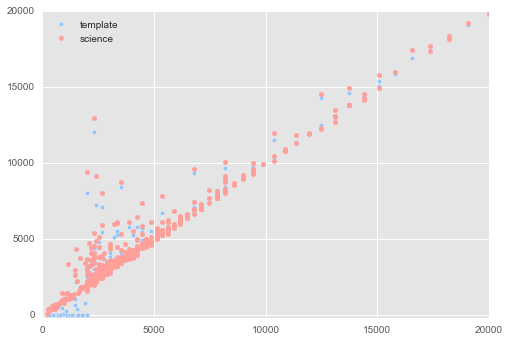

In [12]:
mc1, sources = doForcedPhotometry(testObj, testObj.im1.asAfwExposure())
mc2, sources = doForcedPhotometry(testObj, testObj.im2.asAfwExposure())

plt.scatter(sources['inputFlux_science'], mc1['base_PsfFlux_flux'], label='template')
plt.scatter(sources['inputFlux_science'], mc2['base_PsfFlux_flux'], label='science', color='r')
plt.legend(loc='upper left')
plt.xlim(0, 20000)
plt.ylim(-200, 20000);

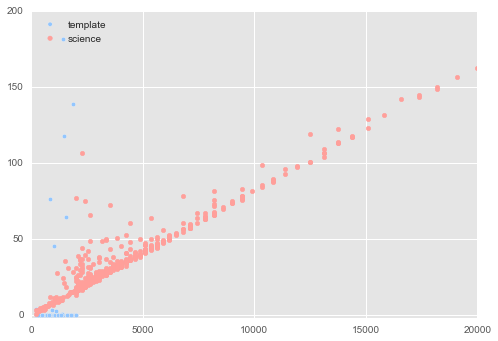

In [13]:
plt.scatter(sources['inputFlux_science'], mc1['base_PsfFlux_flux']/mc1['base_PsfFlux_fluxSigma'], label='template')
plt.scatter(sources['inputFlux_science'], mc2['base_PsfFlux_flux']/mc2['base_PsfFlux_fluxSigma'], label='science', color='r')
plt.legend(loc='upper left')
plt.xlim(0, 20000)
plt.ylim(-2, 200);

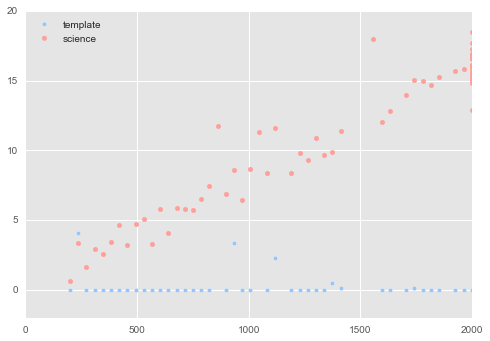

In [14]:
plt.scatter(sources['inputFlux_science'], mc1['base_PsfFlux_flux']/mc1['base_PsfFlux_fluxSigma'], label='template')
plt.scatter(sources['inputFlux_science'], mc2['base_PsfFlux_flux']/mc2['base_PsfFlux_fluxSigma'], label='science', color='r')
plt.legend(loc='upper left')
plt.xlim(0, 2000)
plt.ylim(-2, 20);

50


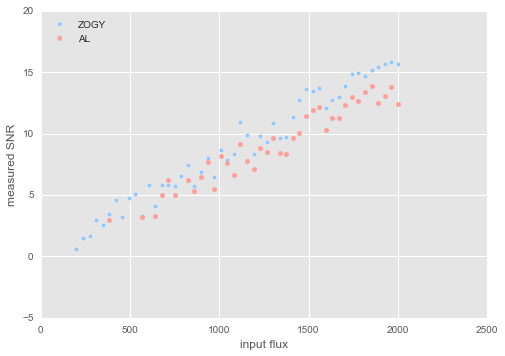

In [15]:
mc1, sources = doForcedPhotometry(testObj, testObj.D_ZOGY.asAfwExposure(), transientsOnly=True)
mc2, sources = doForcedPhotometry(testObj, testObj.res.decorrelatedDiffim, transientsOnly=True)

plt.scatter(sources['inputFlux_science'], mc1['base_PsfFlux_flux']/mc1['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], mc2['base_PsfFlux_flux']/mc2['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
#plt.xlim(0, 2000)
#plt.ylim(0, 50)
print len(sources['inputFlux_science'])

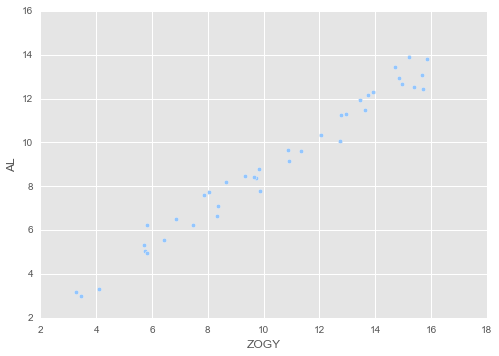

In [16]:
plt.scatter(mc1['base_PsfFlux_flux']/mc1['base_PsfFlux_fluxSigma'], 
            mc2['base_PsfFlux_flux']/mc2['base_PsfFlux_fluxSigma'])
plt.xlabel('ZOGY')
plt.ylabel('AL');

Again, an input flux of ~650 is equal to an SNR of 5.0 in the science image.

For these with noiseless templates, an input flux of ~650 is *also* equal to an SNR of 5.0 in the diffims. (With the noisy template, and noise equal in both images, it was closer to ~900.)